<h1 style="text-align: center;">Trabalho Prático</h1>

<h2 style="text-align: center;">Influência do Desbalanceamento de Classes no Algoritmo SVM</h2>

<h3 style="text-align: center;">Aprendizagem Computacional I - FCUP 2025</h3>

<p style="text-align: center;">Trabalho realizado por:</p>
<p style="text-align: center;">Diogo Nogueira Padilha, 202305188</p>
<p style="text-align: center;">Leonor Oliveira Rodrigues, 202304869</p>
<p style="text-align: center;">Rita Sofia Barbosa Nunes, 202305232</p>



# Imports

In [ ]:
import numpy as np
import scipy.spatial.distance as dist
import os
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.metrics import geometric_mean_score
from scipy.stats import wilcoxon
from matplotlib.patches import Patch

# Desbalanceamento dos Datasets

Antes de avaliar o desempenho do SVM, é fundamental compreender o grau de desbalanceamento presente nos 49 datasets utilizados. Os gráficos focam-se na percentagem da classe minoritária e no grau de desbalanceamento.

É importante referir que o dataset "dataset_1039_hiva_agnostic.csv" foi excluído da análise, uma vez que, com 4229 linhas e 1618 colunas, apresentava um tempo de execução extremamente elevado, tornando inviável a sua inclusão nos testes.

In [ ]:
PASTA_DATASETS = "class_imbalance"

# Lista onde serão guardadas as informações de cada dataset
dados = []

for ficheiro in os.listdir(PASTA_DATASETS):
    caminho = os.path.join(PASTA_DATASETS, ficheiro)
    df = pd.read_csv(caminho)
    y = df.iloc[:, -1].values  # Assume que a última coluna é o target

    contagem = Counter(y)
    menor = min(contagem.values())
    maior = max(contagem.values())
    total = menor + maior

    ratio = menor / maior if maior > 0 else 0     # Desbalanceamento
    pct_min = menor / total * 100                 # Percentagem da classe minoritária

    dados.append({
        'dataset': ficheiro.replace('.csv', ''),
        'pct_min': pct_min,
        'desbalanceamento': ratio
    })

df_distribuicao = pd.DataFrame(dados)

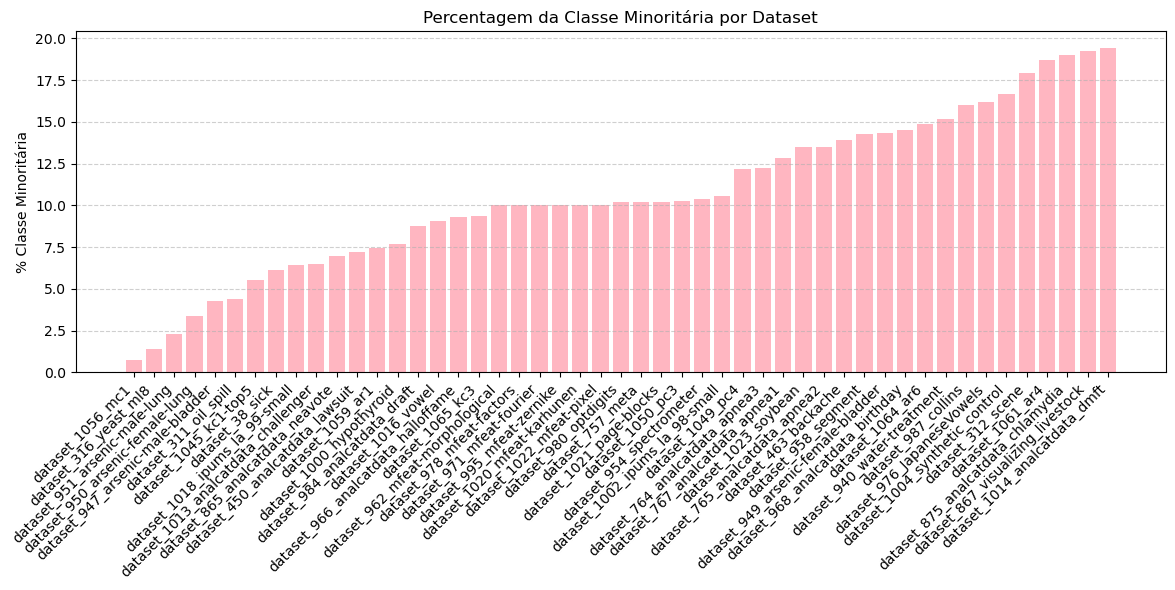

In [ ]:
plt.figure(figsize=(12, 6))
df_sorted_pct = df_distribuicao.sort_values(by='pct_min')   # organiza os datasets por percentagem da classe minoritária
bars = plt.bar(df_sorted_pct['dataset'], df_sorted_pct['pct_min'], color='lightpink')

plt.xticks(rotation=45, ha='right')
plt.ylabel('% Classe Minoritária')
plt.title('Percentagem da Classe Minoritária por Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Valor de desbalanceamento:
- Próximo de 1 - classes balanceadas
- Próximo de 0 - classes desbalanceadas 

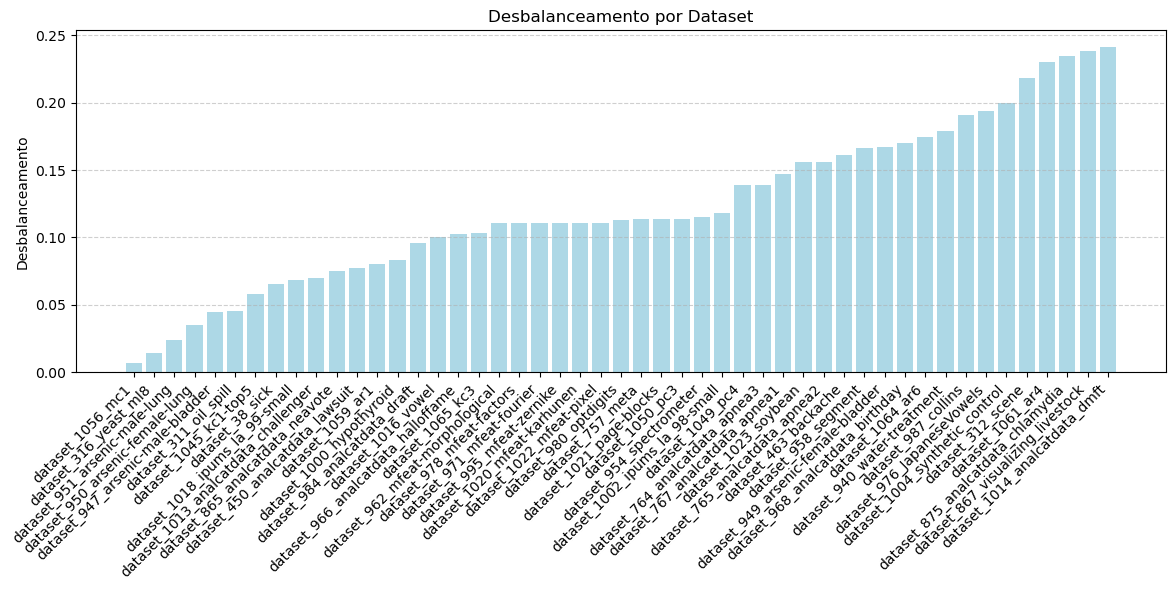

In [ ]:
plt.figure(figsize=(12, 6))
df_sorted_ratio = df_distribuicao.sort_values(by='desbalanceamento')    # organiza os datasets por nível de desbalanceamento
bars = plt.bar(df_sorted_ratio['dataset'], df_sorted_ratio['desbalanceamento'], color='lightblue')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Desbalanceamento')
plt.title('Desbalanceamento por Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Os gráficos mostram uma tendência crescente porque ambas as métricas (percentagem da classe minoritária e desbalanceamento) aumentam à medida que os datasets se tornam mais equilibrados. Isto é, à medida que a classe minoritária se torna proporcionalmente maior em relação à classe maioritária, ambas as métricas aumentam.

# SVM

In [40]:
class Linear(object):
    '''Produto escalar entre vetores x e y.'''
    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class Poly(object):
    '''Produto interno entre vetores x e y elevado a um grau a escolher.'''
    def __init__(self, degree=2):  # se não for atribuído, assume grau padrão de 2 -> quadrático
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Poly kernel"


class RBF(object):
    '''Distância euclidiana entre vetores x e y, elevada a -gamma.'''
    def __init__(self, gamma=0.1):
        self.gamma = gamma   # parâmetro de largura do kernel. Quanto maior o valor, mais estreita a função de decisão.

    def __call__(self, x, y):
        x = np.atleast_2d(x)   # garante que x e y são matrizes 2D, mesmo que tenham apenas uma linha ou coluna
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2).flatten()    # cdist calcula a distância euclidiana entre todos os pontos x e y, o resultado é elevado a -gamma

    def __repr__(self):
        return "RBF kernel"

In [ ]:
class BaseEstimator:
    y_required = True
    fit_required = True   # fit é obrigatório para o modelo funcionar antes de predict

    def _setup_input(self, X, y=None):
        '''Verifica se o input de X e y está no formato correto e guarda os
        dados em atributos da classe.

        Parametros: 
        ----------
        X : array dos atributos da classe
        y : array dos targets da classe
        ----------
        '''

        if not isinstance(X, np.ndarray):
            X = np.array(X)    # converte X para um array numpy se não for, para o modelo ter sempre o mesmo formato

        if X.size == 0:
            raise ValueError("Got an empty matrix.")    # verifica se X não está vazio

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape     # se X for 1D, então tem apenas uma amostra e o número de features é o tamanho do array (uma linha)
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])   # se X for 2D, então o número de amostras é o número de linhas e o número de features é o produto do número de colunas

        self.X = X

        if self.y_required:     # y_required obrigatório para supervised learning
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)     # converte y para um array numpy se não for

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")   # verifica se y não está vazio

        self.y = y

    def fit(self, X, y=None):
        '''Prepara os dados chamando setup_input - Treino'''
        self._setup_input(X, y)

    def predict(self, X=None):
        '''Previsão dos dados com o modelo treinado - Teste'''
        if not isinstance(X, np.ndarray):
            X = np.array(X)    # converte X para um array numpy se não for

        if self.X is not None or not self.fit_required:  # se o modelo já foi treinado, então X não pode ser None
            return self._predict(X)
        else:
            raise ValueError("You must call 'fit' before 'predict'")

    def _predict(self, X=None):
        raise NotImplementedError()

## SVM Original

Este código implementa o SVM (Support Vector Machine) com o SMO (Sequential Minimal Optimization) simplificado, sem usar a biblioteca do scikit-learn. 

O SVM é um classificador de classes binárias que procura o hiperplano ótimo que separa duas classes com a maior margem possível. Para tal, treina o modelo com SMO, que atualiza iterativamente dois alphas de cada vez, respeitando as restrições implementadas. Identifica os vetores de suporte, os únicos pontos com alpha > 0, que influenciam a margem de decisão. De seguida, utiliza uma função de decisão baseada no produto escalar ponderado com os alphas, y e valores do kernel, somado ao bias b. Por fim, permite fazer previsões sobre novos pontos após o treino.

In [ ]:
np.random.seed(9999)

class SVM(BaseEstimator):
    ''' Support Vector Machine com otimização SMO (Sequencial minimal optimization) simplificada'''
    def __init__(self, C=0.6, kernel=None, tol=1e-3, max_iter=200):
        self.C = C                 # parâmetro de regularização, float, default 1.0 (o quanto penaliza o erro de treino)
        self.tol = tol             # tolerância para convergência de treino, float, default 1e-3
        self.max_iter = max_iter   # número máximo de iterações de treino, int, default 100
        if kernel is None:         # se kernel não for atribuído, então é linear
            self.kernel = Linear()
        else:
            self.kernel = kernel

        self.b = 0          # bias do modelo, default 0.0
        self.alpha = None   # vetor dos alphas/pesos que cada ponto tem no modelo, default None
        self.K = None       # matriz de kernel/similaridade entre os pontos, default None

    def fit(self, X, y=None):
        '''Preparação para o treino'''
        self._setup_input(X, y)                                # dados preparados em setup_input
        self.K = np.zeros((self.n_samples, self.n_samples))    # matriz de kernel/similaridade, iniciada a zeros, com o tamanho do número de amostras
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :])   # calcula o kernel entre cada ponto e o ponto i, e coloca o resultado na coluna i da matriz K
        self.alpha = np.zeros(self.n_samples)                  # vetor de alphas/pesos, iniciado a zeros, com o tamanho do número de amostras
        self.sv_idx = np.arange(0, self.n_samples)             # indices dos vetores de suporte. inicialmente, assume que todos os exemplos são vetores de suporte 
        return self._train()

    def _train(self):
        '''Treino do modelo com SMO'''
        iters = 0
        while iters < self.max_iter:                 # enquanto o número de iterações for menor que o máximo definido
            iters += 1
            alpha_prev = np.copy(self.alpha)         # guarda cópia dos alphas anteriores, para verificar se houve convergência

            for j in range(self.n_samples):
                i = self.random_index(j)             # escolhe um índice aleatório diferente de j, para não escolher o mesmo ponto duas vezes

                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]   # eta -> mede a curvatura da função de otimização quando alteramos alpha[i] e alpha[j]
                if eta >= 0:                                             # eta positivo indica que não compensa a alteração de alpha[j]
                    continue
                L, H = self._find_bounds(i, j)                           # intervalo [L, H] para o novo alpha[j], respeitando as restrições do SMO

                e_i, e_j = self._error(i), self._error(j)                # erro para os pontos i e j

                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]        # guarda os alphas anteriores i e j para comparar

                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta         # atualiza o alpha[j] segundo a fórmula do SMO
                self.alpha[j] = self.clip(self.alpha[j], H, L)           # garante que o alpha[j] está dentro ds limites [L, H]

                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])   # atualiza o alpha[i], para compensar o ajuste em alpha[j] segundo a fórmula do SMO

                # bias b serve para ajustar a margem de separação entre classes
                b1 = (
                    self.b - e_i - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i]
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                )
                b2 = (
                    self.b - e_j - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j]
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]
                )                                                                                 # calcula b1 e b2 para os pontos i e j, candidatos para b, segundo a fórmula do SMO
                if 0 < self.alpha[i] < self.C:
                    self.b = b1
                elif 0 < self.alpha[j] < self.C:
                    self.b = b2                                   # atribui b1 ou b2 ao bias b, dependendo de qual alpha pertence a 0 < alpha < C (vetores de suporte)
                else:
                    self.b = 0.5 * (b1 + b2)                      # se nenhum for vetor de suporte, tira a média dos dois b1 e b2

            # Verifica convergência
            diff = np.linalg.norm(self.alpha - alpha_prev)        # calcula a diferença entre os alphas atuais e os anteriores
            if diff < self.tol:
                break
        print("Convergence has reached after %s." % iters)

        self.sv_idx = np.where(self.alpha > 0)[0]    # guarda os índices dos vetores de suporte, que são os pontos com alpha > 0

    def _predict(self, X=None):
        '''Previsão dos dados com o modelo treinado - Teste'''
        n = X.shape[0]    # número de amostras/linhas a prever
        result = np.zeros(n)   # array iniciado a zeros para guardar os resultados
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i, :]))    # previsão para cada linha de X, chamando _predict_row que calcula o valor da função de decisão; np.sign retorna 1 ou -1
        return result

    def _predict_row(self, X):
        '''Função de decisão para prever o valor de um ponto X'''
        k_v = self.kernel(self.X[self.sv_idx], X)    # calcula o kernel entre cada vetor de suporte e o novo ponto X a prever, coloca num vetor k_v o resultado
        return np.dot((self.alpha[self.sv_idx] * self.y[self.sv_idx]).T, k_v.T) + self.b
    # função de decisão: produto entre os pesos alpha e os targets y, multiplicado pelo vetor k_v das similaridades, 
    # para cada vetor de suporte, e o resultado é somado ao bias b do treino.

    def clip(self, alpha, H, L):
        '''Garante que alpha está dentro dos limites [L, H]'''
        if alpha > H:        # se depois de atualizar alpha, ele ficar fora dos limites, volta ao intervalo permitido
            alpha = H
        if alpha < L:
            alpha = L
        return alpha         # retorna alpha corrigido dentro dos limites [L, H]

    def _error(self, i):
        """Erro do modelo para o ponto i"""
        return self._predict_row(self.X[i]) - self.y[i]      # previsto - real

    def _find_bounds(self, i, j):
        '''Calcula os limites L e H para o novo alpha[j], tal que L <= alpha[j] <= H e 0 <= alpha[j] <= C'''
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H

    def random_index(self, z):
        '''Escolhe um índice aleatório diferente de z'''
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples - 1)
        return i

## SVM Modificado

A nova implementação do SVM, designado por SVM Modificado, implementa as 4 propostas sugeridas, com o objetivo de melhorar o desempenho, principalmente para as classes minoritárias:

    - Seleção informada dos pares (i, j)
    - Penalização diferenciada com Ck
    - Margens assimétricas no cálculo do erro
    - Ajuste pós-treino do bias (b)

In [ ]:
np.random.seed(9999)

class SVM_Modificado(BaseEstimator):
    def __init__(self, C=0.6, kernel=None, tol=1e-3, max_iter=200, minority_every_n_iters=5, minority_cost_weight=20, rho_minority=1.2, rho_majority=1.0):
        self.C = C
        self.kernel = kernel if kernel is not None else Linear()
        self.tol = tol
        self.max_iter = max_iter
        self.minority_every_n_iters = minority_every_n_iters   ### Proposta 1 ###
        self.minority_cost_weight = minority_cost_weight       ### Proposta 2 ###
        self.rho_minority = rho_minority                       ### Proposta 3 ###
        self.rho_majority = rho_majority                       ### Proposta 3 ###

        self.b = 0
        self.alpha = None
        self.K = None
        self.sv_idx = None

    def fit(self, X, y=None, X_val=None, y_val=None):
        self._setup_input(X, y)
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :])
        self.alpha = np.zeros(self.n_samples)
        self.sv_idx = np.arange(self.n_samples)
        self.it = self._train()
        
        ##################### Proposta 4 ############################
        if X_val is not None and y_val is not None:
            self.ajustar_bias_gmean(X_val, y_val)
        #############################################################

        return self
    
    def _train(self):
        ###################### Proposta 1 e 2 ##############################
        self.minority_indices = np.where(self.y == 1)[0]   # Identifica os índices da classe minoritária / positiva
        ####################################################################

        ######################## Proposta 2 #################################
        self.Ck = np.full(self.n_samples, self.C)   # Vetor Ck para penalizações diferenciadas
        self.Ck[self.minority_indices] = self.C * self.minority_cost_weight   # Exemplos da classe minoritária recebem uma penalização maior
        #####################################################################

        iters = 0
        while iters < self.max_iter:
            iters += 1
            alpha_prev = np.copy(self.alpha)

            ################################### Proposta 1 ######################################
            for j in range(self.n_samples):
                # A cada 5 iterações, escolher i da classe minoritária
                if iters % self.minority_every_n_iters == 0:
                    # Escolher um índice aleatório da classe minoritária que seja diferente de j
                    i = j
                    while i == j:
                        i = np.random.choice(self.minority_indices)
                else:
                    i = self.random_index(j)
            #####################################################################################

                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                if eta >= 0:
                    continue

                L, H = self._find_bounds(i, j)
                e_i, e_j = self._error(i), self._error(j)

                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]
                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta
                self.alpha[j] = self.clip(self.alpha[j], H, L)
                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])

                b1 = (
                    self.b - e_i - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i]
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                )
                b2 = (
                    self.b - e_j - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j]
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]
                )

                ################################# Proposta 2 ####################################
                # Ao atualizar o bias 'b', é necessário reescrever os novos limites Ck[i] e Ck[j]
                if 0 < self.alpha[i] < self.Ck[i]:
                    self.b = b1
                elif 0 < self.alpha[j] < self.Ck[j]:
                    self.b = b2
                else:
                    self.b = 0.5 * (b1 + b2)
                #################################################################################


            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break

        print("Convergence reached after %s iterations." % iters)
        self.sv_idx = np.where(self.alpha > 0)[0]
        
        return iters
    
    ############################ Proposta 4 ###############################
    def ajustar_bias_gmean(self, X_val, y_val, min_b=-1.0, max_b=1.0, steps=100):
        ''' Ajuste do bias b após o treino para otimizar a métrica G-Mean no conjunto de validação'''
        melhor_b = self.b
        melhor_gmean = -1.0
        # Gera candidatos a bias em torno do valor atual de b
        bs = np.linspace(self.b + min_b, self.b + max_b, steps)

        for b_candidato in bs:
            self.b = b_candidato
            y_pred = self._predict(X_val)               # Faz previsões com o novo bias
            gmean = geometric_mean_score(y_val, y_pred) # Calcula a G-Mean no conjunto de validação

            if gmean > melhor_gmean:
                melhor_gmean = gmean
                melhor_b = b_candidato
        # Após testar todos os candidatos, fixa o melhor bias encontrado
        self.b = melhor_b
        return melhor_b, melhor_gmean
    ######################################################################

    def _predict(self, X):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i]))
        return result

    def _predict_row(self, X):
        k_v = self.kernel(self.X[self.sv_idx], X)
        return np.dot((self.alpha[self.sv_idx] * self.y[self.sv_idx]), k_v) + self.b

    #################### Proposta 2 #######################
    def _find_bounds(self, i, j):
        '''Reescrito para incluir o Ck'''
        # Recupera os custos C individuais para os exemplos i e j, permitindo penalizações diferentes
        Ci, Cj = self.Ck[i], self.Ck[j]
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(Cj, Ci + self.alpha[j] - self.alpha[i])
        else:
            L = max(0, self.alpha[j] + self.alpha[i] - Ci)
            H = min(Cj, self.alpha[j] + self.alpha[i])
        return L, H          # Devolve os limites inferior (L) e superior (H)
    #######################################################

    def clip(self, alpha, H, L):
        '''Garante que alpha está dentro dos limites [L, H]'''
        if alpha > H:        # se depois de atualizar alpha, ele ficar fora dos limites, volta ao intervalo permitido
            alpha = H
        if alpha < L:
            alpha = L
        return alpha         # retorna alpha corrigido dentro dos limites [L, H]

    ######################## Proposta 3 ############################
    def _error(self, i):
        """Erro do modelo para o ponto i, ajustado com margens assimétricas"""
        fx = self._predict_row(self.X[i])
        if self.y[i] == 1:
            return fx - self.y[i] * self.rho_minority     # Para a classe minoritária, o modelo é incentivado a um erro menor
        else:
            return fx - self.y[i] * self.rho_majority
    ###############################################################

    def _setup_input(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]

    def random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples)
        return i

# Visualização com PCA

Introduzimos PCA como técnica de visualização, projetando os dados para duas dimensões para facilitar a interpretação dos limites de decisão dos classificadores. O treino e a previsão dos modelos foram realizados no espaço original.

De forma adicional, a partir dos PCA, juntamente com fundamentos teóricos, escolhemos o kernel que iremos utilizar para alterações e comparações no projeto - kernel Linear. 

In [ ]:
# Balanceado
X, y = make_classification(       
        n_samples=1200, n_features=10, n_informative=5, random_state=1111, n_classes=2, class_sep=1.75
    )
# Converter para {-1, 1}, divisão 80%/20%
y = (y * 2) - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1111)

# Desbalanceado - 95% vs 5%
Xa, ya = make_classification(   
        n_samples=1200, n_features=10, n_informative=5, random_state=1111, n_classes=2, weights=[0.95, 0.05], class_sep=1.75
    )
# Converter para {-1, 1}, divisão 80%/20%
ya = (ya * 2) - 1
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, stratify=ya, test_size=0.2, random_state=1111)

# Para certificar que está a utilizar a proporção tanto no treino como no teste
print("Distribuição original:", np.bincount(ya + 1))  # para ver 0s e 2s como 1 e -1
print("Distribuição no treino:", np.bincount(ya_train + 1))
print("Distribuição no teste:", np.bincount(ya_test + 1))


Distribuição original: [1135    0   65]
Distribuição no treino: [908   0  52]
Distribuição no teste: [227   0  13]


In [ ]:
models = {
    "RBF": SVM(kernel=RBF(gamma=0.1), C=0.6, max_iter=500),
    "Linear": SVM(kernel=Linear(), C=0.6, max_iter=500),
    "Poly (deg=2)": SVM(kernel=Poly(degree=2), C=0.6, max_iter=500),
}

In [ ]:
def plot_decision_boundaries_with_pca(X_train, X_test, y_train, y_test, models_dict, title):
    # PCA reduzido a 2D
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)
    X_test_2d = pca.transform(X_test)

    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    plt.figure(figsize=(18, 5))
    for i, (name, model) in enumerate(models_dict.items(), 1):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds_binary = np.where(preds == -1, 0, 1)
        y_test_binary = np.where(y_test == -1, 0, 1)  
        
        # Transformar o PCA de volta para o espaço original antes de prever
        grid_original = pca.inverse_transform(grid)
        Z = model.predict(grid_original)
        Z = np.where(Z == -1, 0, 1) 
        Z = Z.reshape(xx.shape)
        
        plt.subplot(1, len(models_dict), i)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
        plt.scatter(X_test_2d[y_test == -1, 0], X_test_2d[y_test == -1, 1], label='-1', alpha=0.6)
        plt.scatter(X_test_2d[y_test == 1, 0], X_test_2d[y_test == 1, 1], label='+1', alpha=0.6)
        plt.title(f"{name}\nAcc={accuracy_score(y_test_binary, preds_binary):.2f}, Rec={recall_score(y_test_binary, preds_binary):.2f}, Prec={precision_score(y_test_binary, preds_binary):.2f}, F1={f1_score(y_test_binary, preds_binary):.2f},\n ROC-AUC={roc_auc_score(y_test_binary, preds_binary):.2f}, G-mean={geometric_mean_score(y_test_binary, preds_binary):.2f}")
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Convergence has reached after 139.
Convergence has reached after 295.
Convergence has reached after 500.


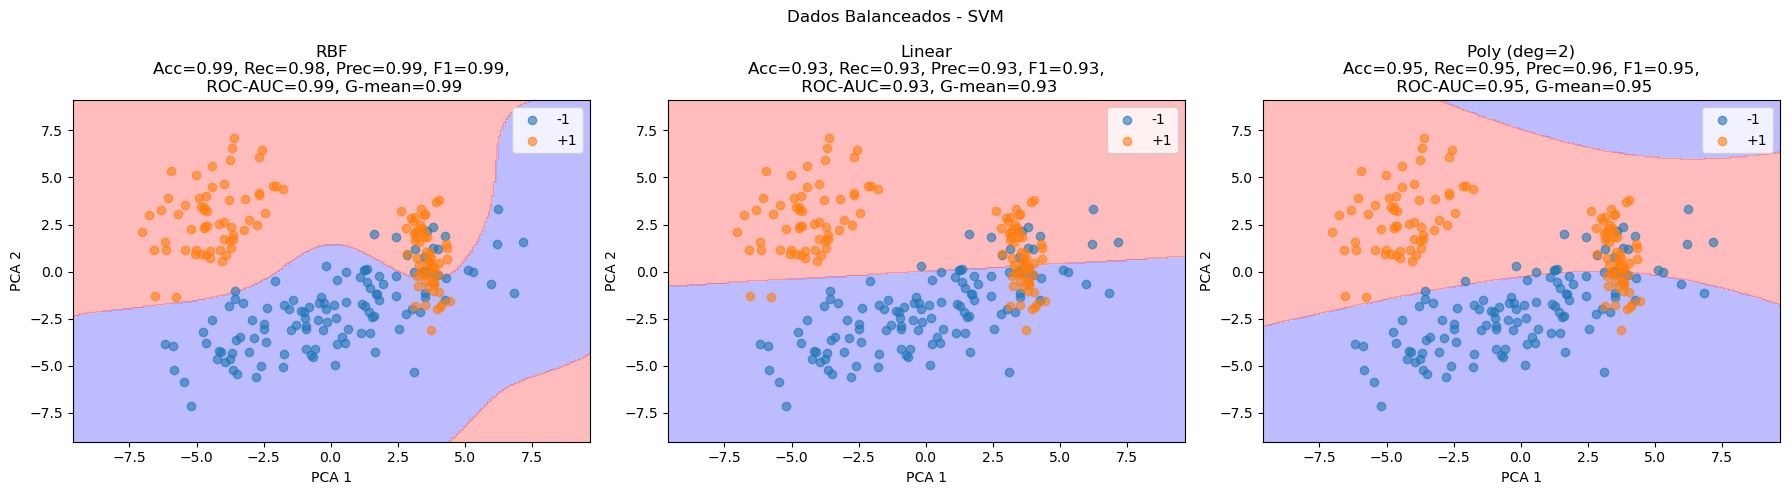

Convergence has reached after 162.
Convergence has reached after 269.
Convergence has reached after 500.


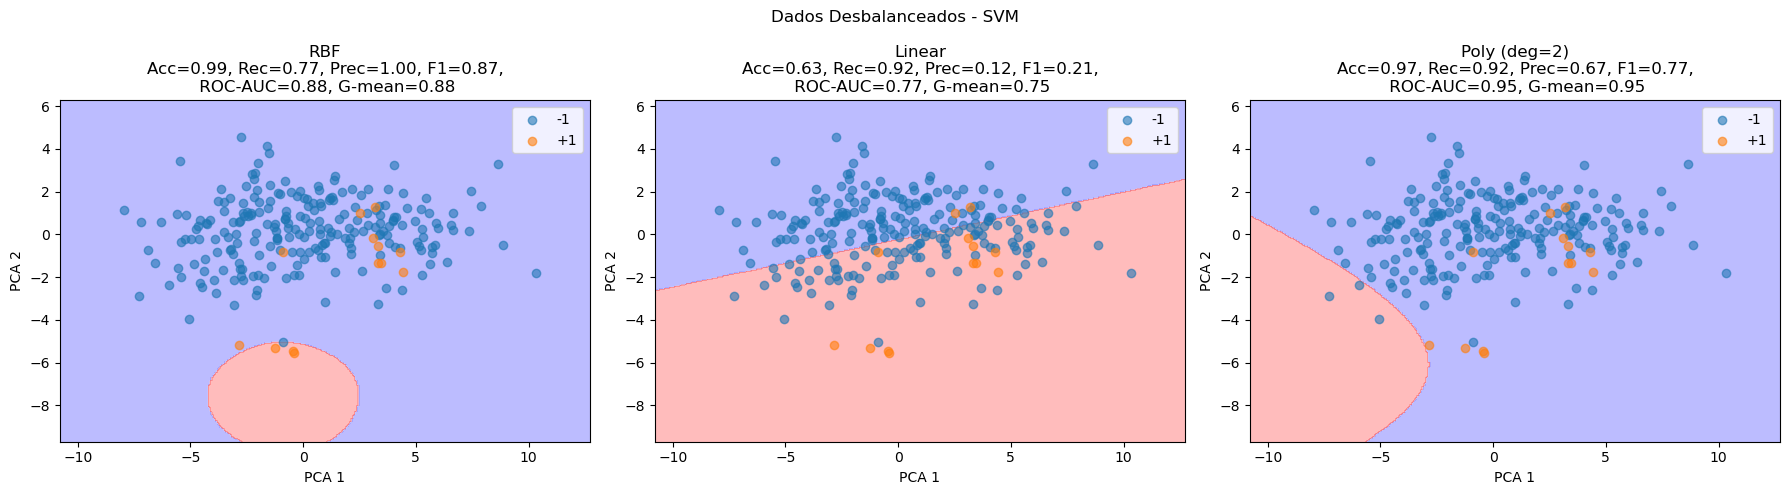

In [41]:

plot_decision_boundaries_with_pca(X_train, X_test, y_train, y_test, models, "Dados Balanceados - SVM")
plot_decision_boundaries_with_pca(Xa_train, Xa_test, ya_train, ya_test, models, "Dados Desbalanceados - SVM")

Deste modo, é possível observar que, nos datasets mais desbalanceados, os pontos da classe minoritária são mais difíceis de separar. Isto ajuda a explicar por que motivo o Recall e o G-Mean, especialmente, tendem a ser inferiores nestes casos. A visualização reforça, portanto, a importância de aplicar estratégias específicas para lidar com o desbalanceamento, como as propostas consideradas neste projeto.

# Pré-Processamento

Nesta fase, definimos funções auxiliares para preparar os dados antes de treinar o SVM. O pré-processamento é essencial para garantir que o modelo recebe entradas limpas e completas.

Para além disso, como estamos perante um problema de classificação binária com classes desbalanceadas, usamos a função ajustar_target_minoritario(y) com o objetivo de identificar automaticamente a classe minoritária com base na frequência da mesma no respetivo dataset. Renomeamos os rótulos de modo que a classe minoritária seja representada por +1 e a maioritária por -1, facilitando a interpretação e a lógica interna do SVM.

Estas etapas são fundamentais, pois garantem que o treino é robusto, coerente e sensível ao desbalanceamento das classes.

In [ ]:
def preprocess_df(df):
    df = df.dropna(axis=1, how='all')

    # Preencher NaNs com a mediana das colunas numéricas
    for col in df.select_dtypes(include=['number']).columns:
        df.loc[:, col] = df[col].fillna(df[col].median())
    
    # Preencher NaNs com o valor mais frequente nas colunas categóricas
    for col in df.select_dtypes(include=['object']).columns:
        df.loc[:, col] = df[col].fillna(df[col].mode()[0])

    # Codificar categorias com LabelEncoder (um por coluna)
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df.loc[:, col] = le.fit_transform(df[col])
    return df


def ajustar_target_minoritario(y):
    classes, counts = np.unique(y, return_counts=True)
    # Identifica a classe minoritária com base nas contagens
    if counts[0] < counts[1]:
        minoritaria, maioritaria = classes[0], classes[1]
    else:
        minoritaria, maioritaria = classes[1], classes[0]

    # Cria um novo vetor y onde a classe minoritária é considerada como 1 e a maioritária como -1
    y_novo = np.where(y == minoritaria, 1, -1)
    return y_novo

# Análise dos datasets

Com o objetivo de avaliar os modelos de forma robusta, utilizamos Stratified 5 Fold Cross Validation.
Este método evita que a avaliação dependa exclusivamente de uma única divisão dos dados, permitindo assim obter uma estimativa mais fiável do desempenho geral do modelo.

Em cada fold, o modelo é treinado com 80% dos dados e testado nos 20% restantes.

## SVM Original, com Cross-Validation

In [ ]:
PASTA_DATASETS = "class_imbalance" 
PASTA_PREDICTIONS = "predictions"

for ficheiro in os.listdir(PASTA_DATASETS):
    caminho = os.path.join(PASTA_DATASETS, ficheiro)
    df = pd.read_csv(caminho)
    df = preprocess_df(df)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    y = ajustar_target_minoritario(y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_idx, (trainval_idx, test_idx) in enumerate(skf.split(X, y)):
        # Dividir em treino + validação (80%) e teste (20%)
        X_trainval, X_test = X[trainval_idx], X[test_idx]
        y_trainval, y_test = y[trainval_idx], y[test_idx]

        svm = SVM(kernel=Linear(), C=0.6, tol=1e-3, max_iter=200)
        svm.fit(X_trainval, y_trainval)  

        y_pred = svm.predict(X_test)

        dset_name = os.path.splitext(os.path.basename(ficheiro))[0]
        ficheiro_saida = os.path.join(PASTA_PREDICTIONS, f"{dset_name}_predictions.csv")
        fold_df = pd.DataFrame({
            "dataset": [dset_name] * len(y_test),
            "fold": [fold_idx] * len(y_test),
            "y_test": y_test,
            "y_pred": y_pred
        })

        escrever_cabecalho = not os.path.exists(ficheiro_saida)
        fold_df.to_csv(ficheiro_saida, mode='a', header=escrever_cabecalho, index=False)

## SVM Modificado, com Cross-Validation

Neste caso, dentro de cada fold da validação cruzada, dividimos ainda os dados de treino (80%) em duas partes: treino (75%) e validação (25%). 

Esta validação interna foi usada para ajustar dinamicamente o bias do modelo, como referido na Proposta 4. Esta abordagem permite otimizar o modelo de forma mais precisa, com base no desempenho observado na validação, sem recorrer diretamente aos dados de teste para esse ajuste.

Os dados de teste de cada fold foram usados apenas na fase final, para avaliar a performance do modelo já otimizado, assegurando uma estimativa fiável da capacidade de generalização.

In [ ]:
PASTA_DATASETS = "class_imbalance"
PASTA_PREDICTIONS = "predictions_modificado"

for ficheiro in os.listdir(PASTA_DATASETS):
    caminho = os.path.join(PASTA_DATASETS, ficheiro)
    df = pd.read_csv(caminho)
    df = preprocess_df(df)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    y = ajustar_target_minoritario(y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_idx, (trainval_idx, test_idx) in enumerate(skf.split(X, y)):
        # Dividir em treino + validação e teste 
        X_trainval, X_test = X[trainval_idx], X[test_idx]
        y_trainval, y_test = y[trainval_idx], y[test_idx]

        # Dividir treino + validação (75% treino, 25% validação dos 80%) 
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, stratify=y_trainval, test_size=0.25, random_state=fold_idx
        )

        svm = SVM_Modificado(kernel=Linear(), C=0.6, tol=1e-3, max_iter=200)
        svm.fit(X_train, y_train, X_val, y_val)  # passa X_val, y_val para ajustar o bias

        y_pred = svm.predict(X_test)

        dset_name = os.path.splitext(os.path.basename(ficheiro))[0]
        ficheiro_saida = os.path.join(PASTA_PREDICTIONS, f"{dset_name}_predictions.csv")
        fold_df = pd.DataFrame({
            "dataset": [dset_name] * len(y_test),
            "fold": [fold_idx] * len(y_test),
            "y_test": y_test,
            "y_pred": y_pred
        })

        escrever_cabecalho = not os.path.exists(ficheiro_saida)
        fold_df.to_csv(ficheiro_saida, mode='a', header=escrever_cabecalho, index=False)

# Métricas de avaliação da performance

Para cada fold, foram calculadas várias métricas:

    - Accuracy 
    - Precision 
    - Recall 
    - F1-score 
    - ROC-AUC 
    - G-mean 
    
Posteriormente, foi calculada a média das métricas entre os 5 folds, representando assim o desempenho geral do modelo naquele dataset.

## SVM Original

In [47]:
FICHEIRO_RESULTADOS = "resultados_svm_linear.csv"

pd.DataFrame(columns=["dataset", "accuracy", "precision", "recall", "f1_score", "roc_auc", "g_mean"]).to_csv(FICHEIRO_RESULTADOS, index=False)

In [ ]:
PASTA_PREDICTIONS = "predictions"

for ficheiro in os.listdir(PASTA_PREDICTIONS):
    caminho = os.path.join(PASTA_PREDICTIONS, ficheiro)
    subset = pd.read_csv(caminho)
    
    metrics_por_fold = []

    for fold_id in subset["fold"].unique():
        fold_data = subset[subset["fold"] == fold_id]
        y_true = fold_data["y_test"]
        y_pred = fold_data["y_pred"]
        y_true = np.where(y_true == -1, 0, 1)   # Converte rótulos de -1 e 1 para 0 e 1, necessário para certas métricas
        y_pred = np.where(y_pred == -1, 0, 1)

        # Calcula as métricas de desempenho
        metrics_por_fold.append({
            "fold": fold_id,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred),
            "g_mean": geometric_mean_score(y_true, y_pred)
        })

    df_metrics = pd.DataFrame(metrics_por_fold)
    media_metrics = df_metrics.mean(numeric_only=True)    # Calcula a média das métricas considerando todos os folds

    linha_final = {
        "dataset": ficheiro,
        "accuracy": round(media_metrics["accuracy"], 3),
        "precision": round(media_metrics["precision"], 3),
        "recall": round(media_metrics["recall"], 3),
        "f1_score": round(media_metrics["f1_score"], 3),
        "roc_auc": round(media_metrics["roc_auc"], 3),
        "g_mean": round(media_metrics["g_mean"], 3)
    }

    escrever_cabecalho = not os.path.exists(FICHEIRO_RESULTADOS)
    pd.DataFrame([linha_final]).to_csv(FICHEIRO_RESULTADOS, mode='a', header=escrever_cabecalho, index=False)  # Adiciona a linha de resultados ao ficheiro final 

## SVM Modificado

In [ ]:

FICHEIRO_RESULTADOS = "resultados_svm_linear_modificado.csv"

pd.DataFrame(columns=["dataset", "accuracy", "precision", "recall", "f1_score", "roc_auc", "g_mean"]).to_csv(FICHEIRO_RESULTADOS, index=False)

In [ ]:
PASTA_PREDICTIONS = "predictions_modificado"

for ficheiro in os.listdir(PASTA_PREDICTIONS):
    caminho = os.path.join(PASTA_PREDICTIONS, ficheiro)
    subset = pd.read_csv(caminho)

    metrics_por_fold = []

    for fold_id in subset["fold"].unique():
        fold_data = subset[subset["fold"] == fold_id]
        y_true = fold_data["y_test"]
        y_pred = fold_data["y_pred"]
        y_true = np.where(y_true == -1, 0, 1)   # Converte rótulos de -1 e 1 para 0 e 1, necessário para certas métricas
        y_pred = np.where(y_pred == -1, 0, 1)

        # Calcula as métricas de desempenho
        metrics_por_fold.append({
            "fold": fold_id,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred),
            "roc_auc": roc_auc_score(y_true, y_pred),
            "g_mean": geometric_mean_score(y_true, y_pred)
        })

    df_metrics = pd.DataFrame(metrics_por_fold)
    media_metrics = df_metrics.mean(numeric_only=True)

    linha_final = {
        "dataset": ficheiro,
        "accuracy": round(media_metrics["accuracy"], 3),
        "precision": round(media_metrics["precision"], 3),
        "recall": round(media_metrics["recall"], 3),
        "f1_score": round(media_metrics["f1_score"], 3),
        "roc_auc": round(media_metrics["roc_auc"], 3),
        "g_mean": round(media_metrics["g_mean"], 3)
    }

    escrever_cabecalho = not os.path.exists(FICHEIRO_RESULTADOS)
    pd.DataFrame([linha_final]).to_csv(FICHEIRO_RESULTADOS, mode='a', header=escrever_cabecalho, index=False)  # Adiciona a linha de resultados ao ficheiro final 

# Confusion Matrix

Foram geradas matrizes de confusão agregadas por dataset, que representam o desempenho final dos modelos ao longo dos 5 folds. Para cada ficheiro de previsões (y_test, y_pred), as classes foram mapeadas para {0, 1} com a classe minoritária sempre representada por 1, assegurando coerência na leitura dos resultados.

Através desta análise é possível:
- Observar diretamente desequilíbrios de classificação, como a existência de muitos falsos negativos (FN), comuns em datasets desbalanceados.
- Avaliar se o modelo favorece a classe maioritária (0), ignorando a deteção da classe minoritária.
- Verificar melhorias no modelo modificado, como a redução de FN ou o aumento de TP, que indicam uma classificação mais correta da classe minoritária.

## SVM

In [85]:
PASTA_PREDICTIONS = "predictions"
os.makedirs("confusion_matrix", exist_ok=True)

for dataset_name in os.listdir(PASTA_PREDICTIONS):
    caminho = os.path.join(PASTA_PREDICTIONS, dataset_name)
    subset = pd.read_csv(caminho)

    y_true = subset["y_test"].astype(int).values
    y_pred = subset["y_pred"].astype(int).values
    y_true = np.where(y_true == -1, 0, 1)  
    y_pred = np.where(y_pred == -1, 0, 1)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[1, 0], yticklabels=[1, 0])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f"Confusion Matrix: {dataset_name}")
    plt.tight_layout()

    caminho = f"confusion_matrix/confusion_matrix_{dataset_name}.png"
    plt.savefig(caminho)
    plt.close()


## SVM Modificado

In [86]:
PASTA_PREDICTIONS = "predictions_modificado"
os.makedirs("confusion_matrix_modificado", exist_ok=True)

for dataset_name in os.listdir(PASTA_PREDICTIONS):
    caminho = os.path.join(PASTA_PREDICTIONS, dataset_name)
    subset = pd.read_csv(caminho)

    y_true = subset["y_test"].astype(int).values
    y_pred = subset["y_pred"].astype(int).values
    y_true = np.where(y_true == -1, 0, 1)  
    y_pred = np.where(y_pred == -1, 0, 1)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[1, 0], yticklabels=[1, 0])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f"Confusion Matrix: {dataset_name}")
    plt.tight_layout()

    caminho = f"confusion_matrix_modificado/confusion_matrix_{dataset_name}.png"
    plt.savefig(caminho)
    plt.close()

# Comparação SVM Original vs. SVM Modificado

In [125]:
df = pd.read_csv("resultados_svm_linear.csv")
df_modificado = pd.read_csv("resultados_svm_linear_modificado.csv")

## Mediana, média e desvio padrão

In [ ]:
mediana_g_mean = df['g_mean'].median()
media_g_mean = df['g_mean'].mean()
desvio_g_mean = df['g_mean'].std()

mediana_g_mean_modificado = df_modificado['g_mean'].median()
media_g_mean_modificado = df_modificado['g_mean'].mean()
desvio_g_mean_modificado = df_modificado['g_mean'].std()

print("===== Comparação de G-Mean entre Modelos =====\n")
print(f"Mediana G-Mean (Original):   {mediana_g_mean:.4f}")
print(f"Mediana G-Mean (Modificado): {mediana_g_mean_modificado:.4f}\n")
print(f"Média G-Mean (Original):   {media_g_mean:.4f}")
print(f"Média G-Mean (Modificado): {media_g_mean_modificado:.4f}\n")
print(f"Desvio Padrão G-Mean (Original): {desvio_g_mean}")
print(f"Desvio Padrão G-Mean (Modificado): {desvio_g_mean_modificado}")

===== Comparação de G-Mean entre Modelos =====

Mediana G-Mean (Original):   0.5570
Mediana G-Mean (Modificado): 0.6560

Média G-Mean (Original):   0.5469
Média G-Mean (Modificado): 0.6419

Desvio Padrão G-Mean (Original): 0.3041117013052084
Desvio Padrão G-Mean (Modificado): 0.24150348584123876


Estes resultados suportam quantitativamente a conclusão de que a versão modificada do SVM consegue melhorar a classificação da classe minoritária, sem sacrificar em excesso o desempenho na classe maioritária.

## Gráfico Desbalanceamento vs. G-Mean

In [127]:
df['dataset'] = df['dataset'].str.replace('_predictions.csv', '', regex=False)
df_comparacao = pd.merge(df_distribuicao[['dataset', 'desbalanceamento']], df[['dataset', 'g_mean']], on='dataset', how='inner')

In [128]:
df_modificado['dataset'] = df_modificado['dataset'].str.replace('_predictions.csv', '', regex=False)
df_comparacao_modificado = pd.merge(df_distribuicao[['dataset', 'desbalanceamento']], df_modificado[['dataset', 'g_mean']], on='dataset', how='inner')

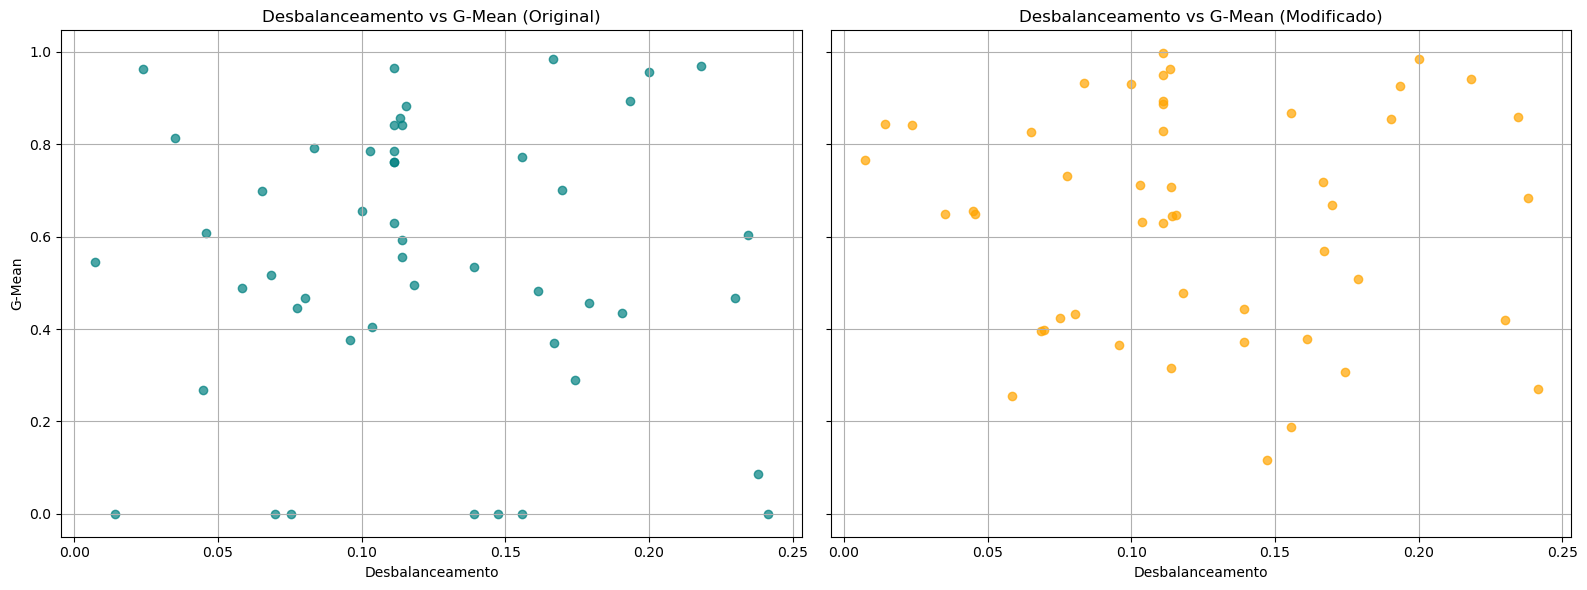

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Gráfico da versão original
axes[0].scatter(df_comparacao['desbalanceamento'], df_comparacao['g_mean'], alpha=0.7, color='teal')
axes[0].set_title('Desbalanceamento vs G-Mean (Original)')
axes[0].set_xlabel('Desbalanceamento')
axes[0].set_ylabel('G-Mean')
axes[0].grid(True)

# Gráfico da versão modificada
axes[1].scatter(df_comparacao_modificado['desbalanceamento'], df_comparacao_modificado['g_mean'], alpha=0.7, color='orange')
axes[1].set_title('Desbalanceamento vs G-Mean (Modificado)')
axes[1].set_xlabel('Desbalanceamento')
axes[1].grid(True)

# Ajuste do layout
plt.tight_layout()
plt.show()

Este gráfico compara o impacto do desbalanceamento no G-Mean. Em ambos os casos, os pontos estão dispersos, sem evidência clara de correlação. 

No entanto, destaca-se que no modelo modificado desaparecem os casos com G-Mean igual a 0, indicando uma melhoria relevante na capacidade de detetar ambas as classes, mesmo em datasets mais desbalanceados.

## Gráfico percentagem da classe minoritária com respetivas melhorias do G-Mean

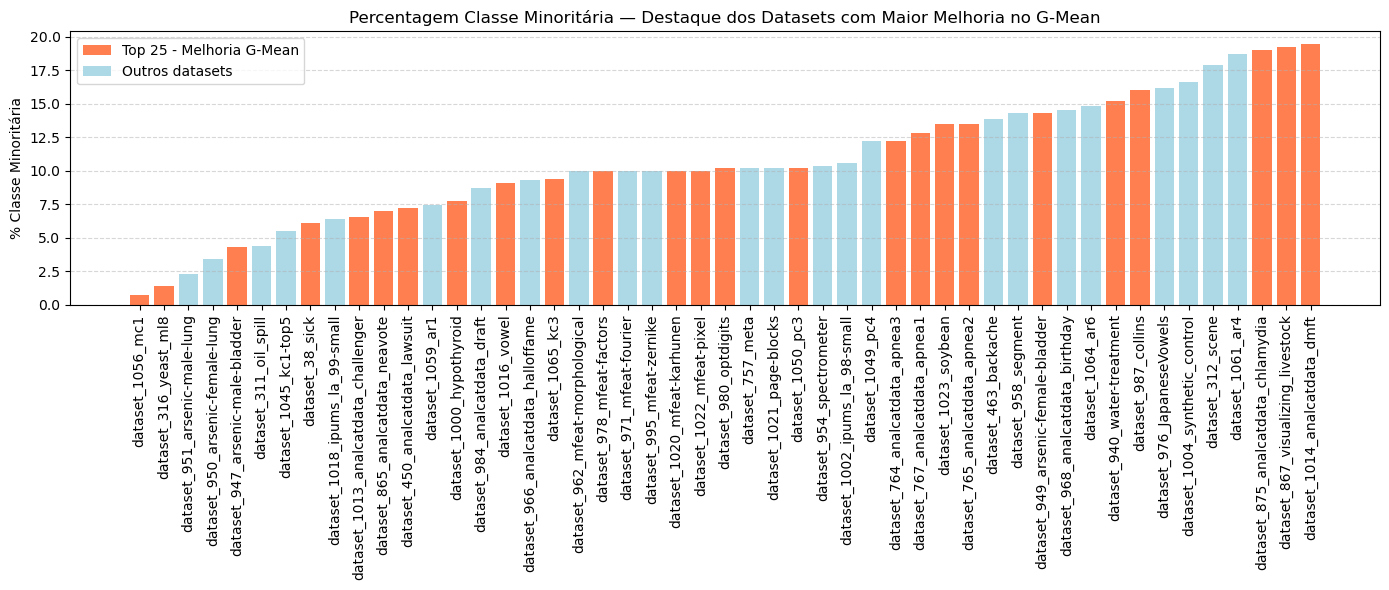

In [130]:
# Garante nomes consistentes
df['dataset'] = df['dataset'].str.replace('_predictions.csv', '', regex=False)
df_modificado['dataset'] = df_modificado['dataset'].str.replace('_predictions.csv', '', regex=False)

# Junta G-means
df_comparacao = pd.merge(df[['dataset', 'g_mean']], df_modificado[['dataset', 'g_mean']], on='dataset', suffixes=('_orig', '_mod'))

# Junta com percentagem da classe minoritária
df_comparacao = pd.merge(df_comparacao, df_distribuicao[['dataset', 'pct_min']], on='dataset')

# Calcula melhoria
df_comparacao['delta_gmean'] = df_comparacao['g_mean_mod'] - df_comparacao['g_mean_orig']

# Top 25 maiores melhorias
top25 = df_comparacao.nlargest(25, 'delta_gmean')['dataset']

# Ordena os datasets por % da min
df_comparacao_sorted = df_comparacao.sort_values(by='pct_min')

# Define cores (coral se está no top25, senão lightblue)
cores = ['coral' if nome in top25.values else 'lightblue' for nome in df_comparacao_sorted['dataset']]

# Gráfico
plt.figure(figsize=(14, 6))
bars = plt.bar(df_comparacao_sorted['dataset'], df_comparacao_sorted['pct_min'], color=cores)

plt.xticks(rotation=90)
plt.ylabel('% Classe Minoritária')
plt.title('Percentagem Classe Minoritária — Destaque dos Datasets com Maior Melhoria no G-Mean')
plt.grid(axis='y', linestyle='--', alpha=0.5)
legend_elements = [
    Patch(facecolor='coral', label='Top 25 - Melhoria G-Mean'),
    Patch(facecolor='lightblue', label='Outros datasets')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


A visualização evidencia que essas melhorias ocorreram tanto em datasets com forte desbalanceamento, ou seja, com uma baixa percentagem da classe minoritária, como nos datasets menos desbalanceados dentro dos existentes. Isto sugere que as modificações realizadas tornam o SVM eficaz tanto para grandes desbalanceamentos como para desbalanceamentos mais moderados, sendo, por isso, um modelo de certa forma robusto dentro de dados desbalanceados.


## Justificação dos resultados do G-Mean 

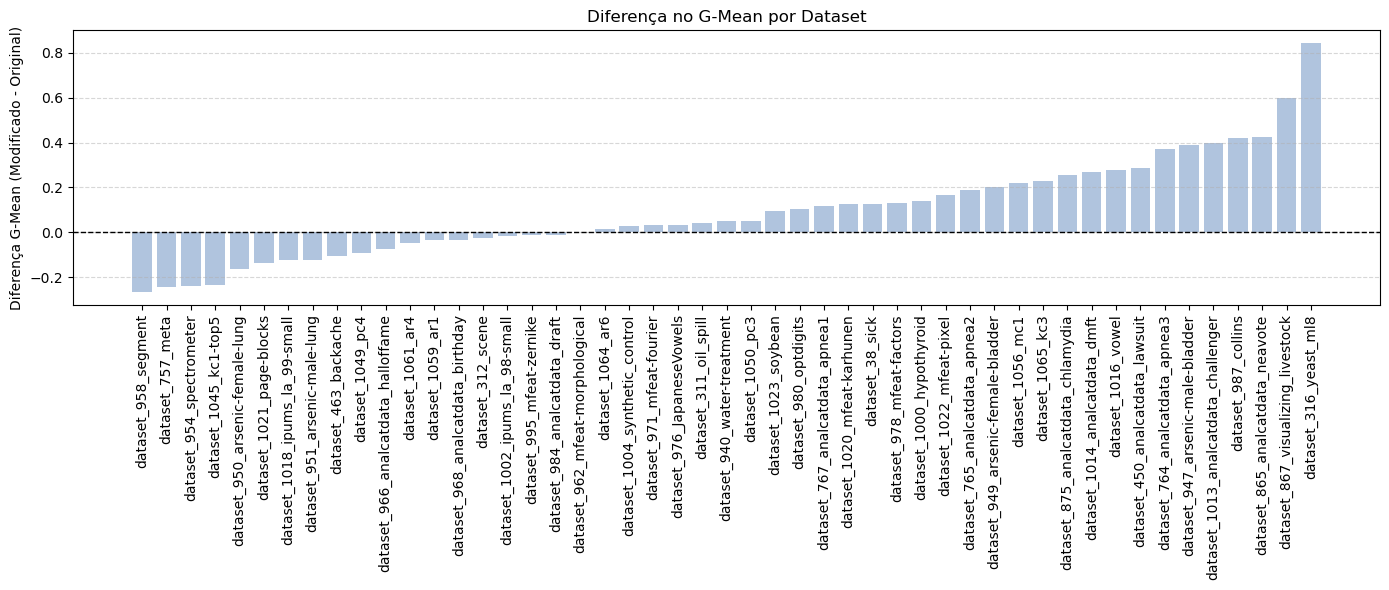

In [ ]:
# Ordena por delta_gmean
df_comparacao_sorted = df_comparacao.sort_values(by='delta_gmean')

plt.figure(figsize=(14, 6))
plt.bar(df_comparacao_sorted['dataset'], df_comparacao_sorted['delta_gmean'], color='lightsteelblue')

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('Diferença G-Mean (Modificado - Original)')
plt.title('Diferença no G-Mean por Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Verifica-se que existiram tanto aumentos como diminuições na métrica do G-Mean, na comparação dos dois modelos. De seguida, iremos tentar compreender os casos em que o G-Mean piorou.

In [ ]:
df['dataset'] = df['dataset'].str.replace('_predictions.csv', '', regex=False)
df_modificado['dataset'] = df_modificado['dataset'].str.replace('_predictions.csv', '', regex=False)

# Junta os recalls no df_comparacao
df_comparacao = pd.merge(df_comparacao, df[['dataset', 'recall']].rename(columns={'recall': 'recall_orig'}), on='dataset')

df_comparacao = pd.merge(df_comparacao, df_modificado[['dataset', 'recall']].rename(columns={'recall': 'recall_mod'}), on='dataset')


# Filtra os casos onde o G-Mean baixou em relação ao SVM original
casos_negativos = df_comparacao[df_comparacao['delta_gmean'] < 0].copy()

# Mostra os recalls original e modificado para esses casos
for _, row in casos_negativos.iterrows():
    print(f"Dataset: {row['dataset']}")
    print(f"  G-Mean Original:   {row['g_mean_orig']:.3f}")
    print(f"  G-Mean Modificado: {row['g_mean_mod']:.3f}")
    print(f"  Recall Original:   {row['recall_orig']:.3f}")
    print(f"  Recall Modificado: {row['recall_mod']:.3f}")
    print(f"  Melhorou Recall?   {'Sim' if row['recall_mod'] > row['recall_orig'] else 'Não'}")
    print('-' * 40)


Dataset: dataset_1002_ipums_la_98-small
  G-Mean Original:   0.495
  G-Mean Modificado: 0.478
  Recall Original:   0.589
  Recall Modificado: 0.723
  Melhorou Recall?   Sim
----------------------------------------
Dataset: dataset_1018_ipums_la_99-small
  G-Mean Original:   0.518
  G-Mean Modificado: 0.396
  Recall Original:   0.926
  Recall Modificado: 0.967
  Melhorou Recall?   Sim
----------------------------------------
Dataset: dataset_1021_page-blocks
  G-Mean Original:   0.842
  G-Mean Modificado: 0.707
  Recall Original:   0.855
  Recall Modificado: 0.779
  Melhorou Recall?   Não
----------------------------------------
Dataset: dataset_1045_kc1-top5
  G-Mean Original:   0.489
  G-Mean Modificado: 0.255
  Recall Original:   0.600
  Recall Modificado: 0.300
  Melhorou Recall?   Não
----------------------------------------
Dataset: dataset_1049_pc4
  G-Mean Original:   0.535
  G-Mean Modificado: 0.443
  Recall Original:   0.472
  Recall Modificado: 0.539
  Melhorou Recall?   Sim


Em vários datasets, como dataset_1002_ipums_la_98-small, dataset_1018_ipums_la_99-small, dataset_1049_pc4, dataset_1059_ar1, dataset_1061_ar4, dataset_463_backache, dataset_954_spectrometer, dataset_958_segment e dataset_995_mfeat-zernike, o G-Mean reduziu, mas o Recall melhorou. Isto pode significar que o modelo está a detetar mais verdadeiros positivos da classe minoritária, ainda que isso tenha ocorrido à custa de um aumento nos falsos positivos. 

Este tipo de comportamento pode ser desejável em contextos mais sensíveis, onde as consequências de não identificar corretamente um caso relevante são mais graves do que as de gerar um falso alarme.

# Teste Estatístico de Wilcoxon

Para avaliar se as diferença estatísticas entre os desempenhos do modelo original (SVM padrão) e do modelo modificado (SVM com propostas 1, 2, 3 e 4) eram significativas, foi utilizado o teste de Wilcoxon para amostras emparelhadas.

A escolha deste teste foi suportada pela análise visual da distribuição das diferenças (ver Boxplot abaixo), que revelou assimetrias e outliers, não compatíveis com uma distribuição normal.

In [ ]:
gmean_original = df['g_mean']               # Coluna g_mean para o modelo original
gmean_modificado = df_modificado['g_mean']  # Coluna g_mean para o modelo modificado

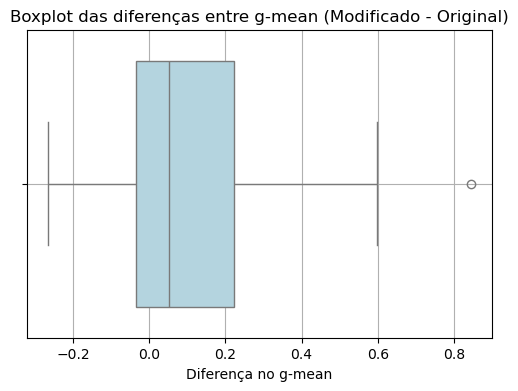

In [ ]:
diffs = gmean_modificado - gmean_original

plt.figure(figsize=(6, 4))
sns.boxplot(x=diffs, color='lightblue')
plt.title("Boxplot das diferenças entre g-mean (Modificado - Original)")
plt.xlabel("Diferença no g-mean")
plt.grid(True)
plt.show()

In [91]:
# Teste de Wilcoxon
stat, p_value = wilcoxon(gmean_original, gmean_modificado)

print("===== Teste de Wilcoxon =====")
print(f"Estatística: {stat}")
print(f"p-valor: {p_value}\n")

if p_value < 0.05:
    print("Há diferença estatística significativa entre os modelos.")
else:
    print("Não há diferença estatística significativa.")

===== Teste de Wilcoxon =====
Estatística: 331.0
p-valor: 0.008390652047713103

Há diferença estatística significativa entre os modelos.


Este resultado permite concluir, com um nível de confiança de 95%, que o SVM modificado apresenta um desempenho (medido pelo G-Mean) significativamente superior ao do SVM original. Este ganho pode ser atribuído às modificações introduzidas no algoritmo, que o tornaram mais sensível à classe minoritária em contextos de desbalanceamento.

# Conclusões

* Este trabalho demonstrou que o algoritmo SVM, na sua versão original, não está preparado para lidar eficazmente com situações de desbalanceamento de classes, uma limitação crítica em muitos cenários do mundo real. Ao tratar todos os erros de forma igual, o modelo tende a favorecer a classe maioritária, comprometendo seriamente a capacidade de identificar corretamente a classe minoritária — muitas vezes a mais relevante.

* Foram propostas e implementadas modificações diretamente no núcleo do algoritmo (SMO), com o objetivo de aumentar a influência da classe minoritária durante o processo de otimização. Através de estratégias como a penalização diferenciada, margens assimétricas e ajustes internos de bias, foi possível reequilibrar o foco do SVM. 

* A eficácia destas alterações foi validada empiricamente com recurso à média e mediana do G-Mean e ao desvio padrão, bem como a diferentes gráficos de comparação e, por fim, confirmada estatisticamente com o Teste de Wilcoxon, que revelou uma melhoria significativa no desempenho do SVM Modificado.

* Estes resultados reforçam que intervenções diretas no algoritmo são essenciais para obter classificações mais justas e eficazes em cenários de desbalanceamento de classes.
